# **Credit Score Classification**


---


**Developed By:**


*   Soueid, Majd
*   Parthasarathy, Naveen
*   Jain, Divisha
*   Kethepalli, Vamsi Gopala Krishna
*   Brittingham, Erika

# **Importing Initial Libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import re
import time
import random
import tempfile
from tqdm.notebook import tqdm
import warnings
import gc

In [ ]:
gc.collect()

8445

# **Supressing Warnings**
This helps with reading the output clearly and avoids warnings associated with the output.

In [ ]:
# Suppress FutureWarning
warnings.simplefilter(action='ignore', category=FutureWarning)

# **EDA and Data Preprocessing**

## Importing Provided Training and Testing Data

In [ ]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

<ipython-input-81-79fa71095500>:1: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv('train.csv')


## Understanding the Data

In [ ]:
df_train.shape, df_test.shape

((100000, 28), (50000, 27))

In [ ]:
display(
    df_train.describe(exclude=np.number).T,
    print(),
    df_test.describe(exclude=np.number).T
)

,count,unique,top,freq
ID,100000,100000,0x1602,1
Customer_ID,100000,12500,CUS_0xd40,8
Month,100000,8,January,12500
Name,90015,10139,Langep,44
Age,100000,1788,38,2833
SSN,100000,12501,#F%$D@*&8,5572
Occupation,100000,16,_______,7062
Annual_Income,100000,18940,36585.12,16
Num_of_Loan,100000,434,3,14386
Type_of_Loan,88592,6260,Not Specified,1408


None

,count,unique,top,freq
ID,50000,50000,0x160a,1
Customer_ID,50000,12500,CUS_0xd40,4
Month,50000,4,September,12500
Name,44985,10139,Stevex,22
Age,50000,976,39,1493
SSN,50000,12501,#F%$D@*&8,2828
Occupation,50000,16,_______,3438
Annual_Income,50000,16121,109945.32,8
Num_of_Loan,50000,263,2,7173
Type_of_Loan,44296,6260,Not Specified,704


In [ ]:
df = pd.concat([df_train, df_test], ignore_index=True)
df.shape

(150000, 28)

## Examining the Data

In [ ]:
df.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                        15000
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary       22500
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                17112
Delay_from_due_date             0
Num_of_Delayed_Payment      10500
Changed_Credit_Limit            0
Num_Credit_Inquiries         3000
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age          13500
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly      6750
Payment_Behaviour               0
Monthly_Balance              1762
Credit_Score                50000
dtype: int64

## Helper Functions


In [ ]:
# Created following functions that will help in exploring, analysing & cleaning of the data

def get_column_details(df,column):
    print("Details of",column,"column")

    # DataType of column
    print("\nDataType: ",df[column].dtype)

    # Check if null values are present
    count_null = df[column].isnull().sum()
    if count_null==0:
        print("\nThere are no null values")
    elif count_null>0:
        print("\nThere are ",count_null," null values")

    # Get Number of Unique Values
    print("\nNumber of Unique Values: ",df[column].nunique())

    # Get Distribution of Column
    print("\nDistribution of column:\n")
    print(df[column].value_counts())

In [ ]:
def fill_missing_with_group_mode(df, groupby, column):
    print("\nNo. of missing values before filling with group mode:",df[column].isnull().sum())

    # Fill with local mode
    mode_per_group = df.groupby(groupby)[column].transform(lambda x: x.mode().iat[0])
    df[column] = df[column].fillna(mode_per_group)

    print("\nNo. of missing values after filling with group mode:",df[column].isnull().sum())

In [ ]:
# Method to clean categorical field

def clean_categorical_field(df,groupby,column,replace_value=None):
    print("\n-----------------------------------------------------")
    print("\nCleaning steps ")

    # Replace with np.nan
    if replace_value!=None:
        df[column] = df[column].replace(replace_value,np.nan)
        print(f"\nGarbage value {replace_value} is replaced with np.nan")

    # For each Customer_ID, assign same value for the column
    fill_missing_with_group_mode(df,groupby,column)

In [ ]:
# Handle Outliers
def handle_outliers(df, groupby, column):
    df_dropped = df[df[column].notna()].groupby(groupby)[column].apply(list)

    # Calculate the mode for each group
    modes = df_dropped.apply(lambda x: stats.mode(x).mode)

    # Calculate the standard deviation for each group
    std_devs = df_dropped.apply(lambda x: np.std(x))

    # Define a threshold for outliers (e.g., values more than 2 standard deviations away from the mode)
    outlier_threshold = modes + 2 * std_devs

    # Replace outliers with NaN
    df[column] = df.apply(lambda row: np.nan if (row[column] > outlier_threshold[row[groupby]]) else row[column], axis=1)

# Fill Null Values
def fill_null_values(df, groupby, column):
    # Fill null values with the mode of the corresponding group
    mode_by_group = df.groupby(groupby)[column].transform(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
    df[column] = df[column].fillna(mode_by_group)

    # Fill remaining null values with the mean of the column
    df[column].fillna(df[column].mean(), inplace=True)

def fix_inconsistent_values(df, groupby, column):
    print("\nExisting Min, Max Values:", df[column].apply([min, max]), sep='\n', end='\n')

    handle_outliers(df, groupby, column)
    fill_null_values(df, groupby, column)

    print("\nAfter Cleaning Min, Max Values:", df[column].apply([min, max]), sep='\n', end='\n')
    print("\nNo. of Unique values after Cleaning:", df[column].nunique())
    print("\nNo. of Null values after Cleaning:", df[column].isnull().sum())

# Example usage
# fix_inconsistent_values(df, groupby, column_name)

In [ ]:
# Method to clean Numerical Field
def clean_numerical_field2(df,groupby,column,strip=None,datatype=None,replace_value=None):
    print("\n-----------------------------------------------------")
    print("\nCleaning steps ")

    # Replace with np.nan
    if replace_value!=None:
        df[column] = df[column].replace(replace_value,np.nan)
        print(f"\nGarbage value {replace_value} is replaced with np.nan")

    # Remove trailing & leading special characters
    if df[column].dtype == object and strip is not None:
        df[column] = df[column].str.strip(strip)
        print(f"\nTrailing & leading {strip} are removed")

    # Change datatype
    if datatype is not None:
        df[column] = df[column].astype(datatype)
        print(f"\nDatatype of {column} is changed to {datatype}")

    fix_inconsistent_values(df, groupby, column)

In [ ]:
def plot_countplot(df, column, user_friendly_column_name, rotation=0, max_xticks=None):
    print("\n-----------------------------------------------------")
    print(f'\n{user_friendly_column_name} Distribution')
    palette = "deep"
    sns.set_palette(palette)

    # Create the count plot
    sns.countplot(data=df, x=column)

    plt.xlabel(f'{user_friendly_column_name}')
    plt.ylabel('Number of Records')
    plt.title(f'{user_friendly_column_name} Distribution')

    # Limit the number of x-axis labels shown and rotate them if needed
    if max_xticks is not None and len(df[column].unique()) > max_xticks:
        step = len(df[column].unique()) // max_xticks
        plt.xticks(range(0, len(df[column].unique()), step), df[column].unique()[::step])
        plt.xticks(rotation=rotation)

    plt.show()

In [ ]:
def plot_displot(df,column,user_friendly_column_name,rotation=0,bins=20):
    print("\n-----------------------------------------------------")
    print(f'\n{user_friendly_column_name} Distribution')
    palette = "deep"
    sns.set_palette(palette)

    sns.displot(data=df, x=column, kde=True, bins=bins)

    plt.xlabel(f'{user_friendly_column_name}')
    plt.ylabel('Number of Records')
    plt.title(f'{user_friendly_column_name} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

In [ ]:
def plot_stacked_bar(df,column1,column2,rotation=0):
    print("\n-----------------------------------------------------")
    print(f'\n{column1} & {column2} Distribution')
    palette = "deep"
    sns.set_palette(palette)

    pd.crosstab(df[column1], df[column2]).plot(kind='bar', stacked=True)

    plt.xlabel(f'{column1}')
    plt.ylabel('Number of Records')
    plt.title(f'{column1} & {column2} Distribution')
    plt.xticks(rotation=rotation)

    plt.show()

## **Categorical Variables**


Details of Credit_Score column

DataType:  object

There are  50000  null values

Number of Unique Values:  3

Distribution of column:

Standard    53174
Poor        28998
Good        17828
Name: Credit_Score, dtype: int64

-----------------------------------------------------

Credit Score Distribution


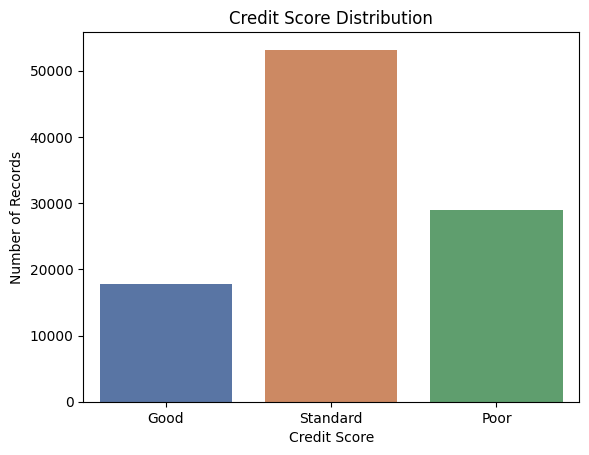

In [ ]:
# Credit Score
column_name = 'Credit_Score'
user_friendly_name = 'Credit Score'

# Get Details
get_column_details(df,column_name)

# Plot Graph
plot_countplot(df,column_name,user_friendly_name)


### **Credit Score Summary**

There are 3 different Credit Score - Standard, Good & Poor.
Distribution of credit score -

* Standard - 53%

* Poor - 29%

* Good - 17%

There are 50000 null values for Credit Score

## Treating ID Column


In [ ]:
# Get Details
get_column_details(df,'ID')

Details of ID column

DataType:  object

There are no null values

Number of Unique Values:  150000

Distribution of column:

0x1602     1
0x162e     1
0x25fea    1
0x25feb    1
0x25fec    1
          ..
0x13afa    1
0x13afb    1
0x13afc    1
0x13afd    1
0x25ff1    1
Name: ID, Length: 150000, dtype: int64


### **ID Summary**

There are 150000 distinct records and no null values present.

## Customer ID

In [ ]:
# Get Details
get_column_details(df,'Customer_ID')

Details of Customer_ID column

DataType:  object

There are no null values

Number of Unique Values:  12500

Distribution of column:

CUS_0xd40     12
CUS_0x9bf4    12
CUS_0x5ae3    12
CUS_0xbe9a    12
CUS_0x4874    12
              ..
CUS_0x2eb4    12
CUS_0x7863    12
CUS_0x9d89    12
CUS_0xc045    12
CUS_0x942c    12
Name: Customer_ID, Length: 12500, dtype: int64


### **Summary**

We have record of 12500 unique customers.
Same customer can have different credit score. It means that on the basis of other values customer credit score can change.

In [ ]:
# Check if same customer can have different credit score
df.groupby(['Customer_ID'])['Credit_Score'].nunique()

Customer_ID
CUS_0x1000    2
CUS_0x1009    1
CUS_0x100b    2
CUS_0x1011    1
CUS_0x1013    1
             ..
CUS_0xff3     2
CUS_0xff4     1
CUS_0xff6     2
CUS_0xffc     2
CUS_0xffd     2
Name: Credit_Score, Length: 12500, dtype: int64

## Treating Month Column

Details of Month column

DataType:  object

There are no null values

Number of Unique Values:  12

Distribution of column:

January      12500
February     12500
March        12500
April        12500
May          12500
June         12500
July         12500
August       12500
September    12500
October      12500
November     12500
December     12500
Name: Month, dtype: int64

-----------------------------------------------------

Month & Credit_Score Distribution


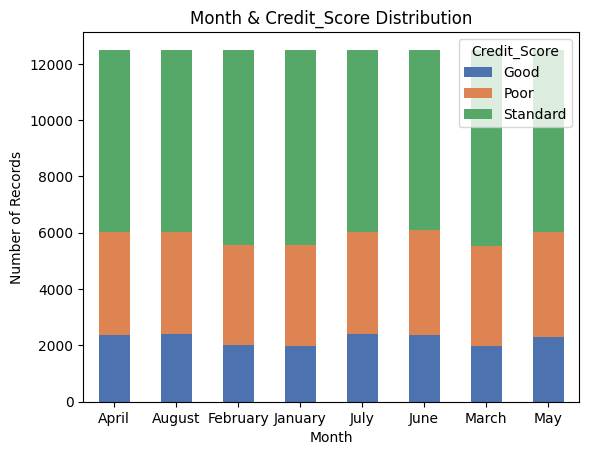

In [ ]:
column_name = 'Month'

# Get Details
get_column_details(df,column_name)

# Plot Distrbution with Credit_Score
plot_stacked_bar(df,column_name,'Credit_Score')

### **Summary**

In the training dataset, we have credit score for each customer over the course of 8 months (from January to August).

Converted Month column from object to datetime value so that it can be further use for model building.

Distribution of Credit_Scrore across different months is similar.

In [ ]:
# Convert Month to datetime object
df['Month'] = pd.to_datetime(df.Month, format='%B').dt.month

## Treating Name Column

In [ ]:
column_name = 'Name'
group_by = 'Customer_ID'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_categorical_field(df,group_by,column_name)

Details of Name column

DataType:  object

There are  15000  null values

Number of Unique Values:  10139

Distribution of column:

Stevex                 66
Langep                 65
Jessicad               59
Vaughanl               58
Raymondr               58
                       ..
Carrick Mollenkampe     7
Giuseppeh               7
Drivera                 7
Emi Emotor              7
Timothyl                6
Name: Name, Length: 10139, dtype: int64

-----------------------------------------------------

Cleaning steps 

No. of missing values before filling with group mode: 15000

No. of missing values after filling with group mode: 0


### **Summary**

There are 15000 null values.

Cleaning Step: Assign same Name value to each Customer_ID

## Treating SSN Column

In [ ]:
column_name = 'SSN'
group_by = 'Customer_ID'
garbage_value = '#F%$D@*&8'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_categorical_field(df,group_by,column_name,garbage_value)

Details of SSN column

DataType:  object

There are no null values

Number of Unique Values:  12501

Distribution of column:

#F%$D@*&8      8400
078-73-5990      12
047-16-1543      12
255-39-8777      12
159-51-7992      12
               ... 
414-76-9835       7
695-71-7676       7
803-44-6289       7
074-52-8105       7
642-73-7670       6
Name: SSN, Length: 12501, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value #F%$D@*&8 is replaced with np.nan

No. of missing values before filling with group mode: 8400

No. of missing values after filling with group mode: 0


### **Summary**

There are 12501 unique SSN values in training dataset.
8400 entries has random/garbage value as SSN value

Steps to Clean SSN:

1. Replace garbage value with np.nan

2. Assign same SSN value for each customer ID

## Treating Occupation Column


Details of Occupation column

DataType:  object

There are no null values

Number of Unique Values:  16

Distribution of column:

_______          10500
Lawyer            9899
Engineer          9562
Architect         9550
Mechanic          9459
Accountant        9404
Scientist         9403
Developer         9381
Media_Manager     9362
Teacher           9318
Entrepreneur      9277
Journalist        9122
Doctor            9114
Manager           8973
Musician          8858
Writer            8818
Name: Occupation, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _______ is replaced with np.nan

No. of missing values before filling with group mode: 10500

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Occupation & Credit_Score Distribution


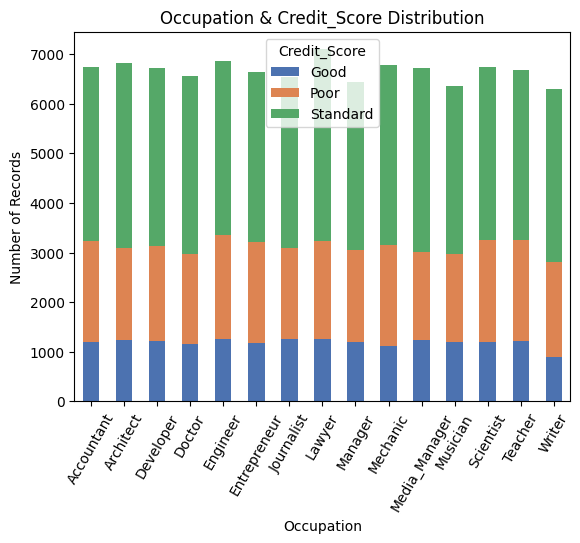

In [ ]:
column_name = 'Occupation'
group_by = 'Customer_ID'
garbage_value = '_______'
user_friendly_name = 'Occupation'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_categorical_field(df,group_by,column_name,garbage_value)

# Plot Distribution with Credit_Score
plot_stacked_bar(df,column_name,'Credit_Score',rotation=60)

### **Summary**

There are 16 unique Occupation values.
10500 records are marked with garbage value.

Steps to Clean Occupation:

1. Replace garbage value with np.nan

2. Assign same Occupation value for each customer ID

Distribution of Credit_Scrore across different occupation is similar.

## Type of loan

In [ ]:
# Get Details of Type of Loan column
get_column_details(df,'Type_of_Loan')

Details of Type_of_Loan column

DataType:  object

There are  17112  null values

Number of Unique Values:  6260

Distribution of column:

Not Specified                                                                                                                         2112
Credit-Builder Loan                                                                                                                   1920
Personal Loan                                                                                                                         1908
Debt Consolidation Loan                                                                                                               1896
Student Loan                                                                                                                          1860
                                                                                                                                      ... 
Not Specified, Mortgage Loa

In [ ]:
# Handle Type of Loan null values
df['Type_of_Loan'].replace([np.NaN], 'Not Specified', inplace=True)

### **Summary**

There are 6260 unique values present for Type of Loan and there are null values present.

Mapped all null values to Not Specificed for Type of Loan column.

## Credit Mix

Details of Credit_Mix column

DataType:  object

There are no null values

Number of Unique Values:  4

Distribution of column:

Standard    54858
Good        36597
_           30000
Bad         28545
Name: Credit_Mix, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _ is replaced with np.nan

No. of missing values before filling with group mode: 30000

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Credit_Mix & Credit_Score Distribution


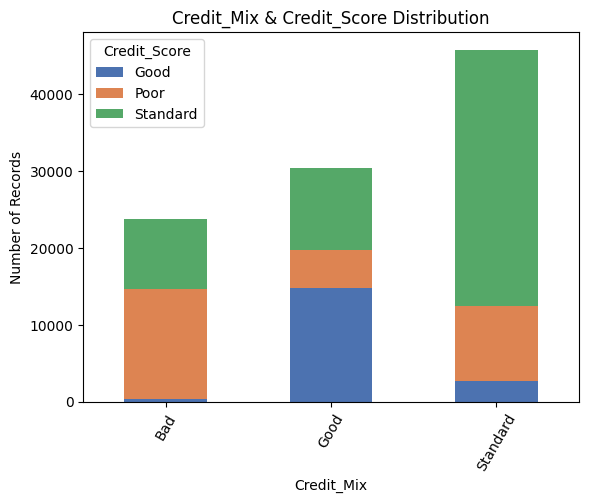

In [ ]:
column_name = 'Credit_Mix'
group_by = 'Customer_ID'
garbage_value = '_'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_categorical_field(df,group_by,column_name,garbage_value)

# Plot Distribution with Credit_Score
plot_stacked_bar(df,column_name,'Credit_Score',rotation=60)

### **Summary**

There are 3 types of Credit Mix: Standard, Good, Bad

About 29k records of Credit Mix is marked as a garbage value (_).

Steps to Clean Credit Mix Field:

1. Replace garbage value with np.nan

2. Assign same Credit Mix value for each customer ID

## Payment of Min Amount

Details of Payment_of_Min_Amount column

DataType:  object

There are no null values

Number of Unique Values:  3

Distribution of column:

Yes    78484
No     53516
NM     18000
Name: Payment_of_Min_Amount, dtype: int64

-----------------------------------------------------

Payment_of_Min_Amount & Credit_Score Distribution


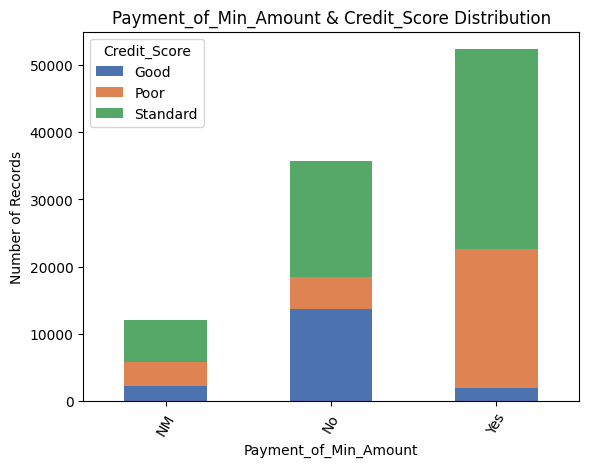

In [ ]:
column_name = 'Payment_of_Min_Amount'

# Get Details
get_column_details(df,column_name)

# Plot Distribution with Credit_Score
plot_stacked_bar(df,column_name,'Credit_Score',rotation=60)

### **Summary**

There are 3 unique values present: Yes, No & NM.

No missing values are present.

## Payment behaviour

Details of Payment_Behaviour column

DataType:  object

There are no null values

Number of Unique Values:  7

Distribution of column:

Low_spent_Small_value_payments      38207
High_spent_Medium_value_payments    26462
Low_spent_Medium_value_payments     20698
High_spent_Large_value_payments     20565
High_spent_Small_value_payments     16991
Low_spent_Large_value_payments      15677
!@9#%8                              11400
Name: Payment_Behaviour, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value !@9#%8 is replaced with np.nan

No. of missing values before filling with group mode: 11400

No. of missing values after filling with group mode: 0

-----------------------------------------------------

Payment_Behaviour & Credit_Score Distribution


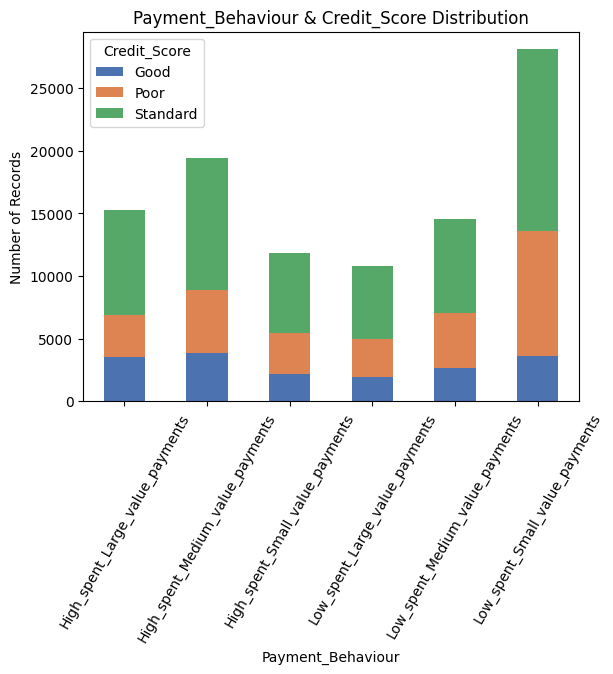

In [ ]:
column_name = 'Payment_Behaviour'
group_by = 'Customer_ID'
garbage_value = '!@9#%8'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_categorical_field(df,group_by,column_name,garbage_value)

# Plot Distribution with Credit_Score
plot_stacked_bar(df,column_name,'Credit_Score',rotation=60)

### **Summary**

There are 6 unique values of Payment Behaviour:

* Low_spent_Small_value_payments
* High_spent_Medium_value_payments
* Low_spent_Medium_value_payments
* High_spent_Large_value_payments
* High_spent_Small_value_payments
* Low_spent_Large_value_payments

38.2k of records are for Low_spent_Small_value_payments.

For 11.4k records, Payment Behaviour is filled with garbage value.

Steps to Clean Payment Behaviour Field:

1. Replace garbage value with np.nan

2. Assign same Payment Behaviour value for each customer ID

## **Numerical Variables**

## Age

Details of Age column

DataType:  object

There are no null values

Number of Unique Values:  2524

Distribution of column:

39      4198
32      4189
28      4173
26      4140
35      4130
        ... 
4655       1
529        1
8386       1
5924       1
5826       1
Name: Age, Length: 2524, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Age is changed to int

Existing Min, Max Values:
min    -500
max    8698
Name: Age, dtype: int64

After Cleaning Min, Max Values:
min    -500.0
max    5172.0
Name: Age, dtype: float64

No. of Unique values after Cleaning: 216

No. of Null values after Cleaning: 0

-----------------------------------------------------

Age Distribution


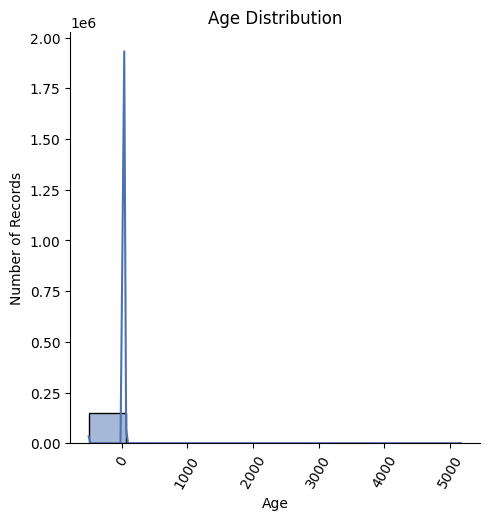

In [ ]:
column_name = 'Age'
group_by = 'Customer_ID'
user_friendly_name = 'Age'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype='int')

# Plot Graph
plot_displot(df,column_name,user_friendly_name,bins=10, rotation = 60)

## Annual income

Details of Annual_Income column

DataType:  object

There are no null values

Number of Unique Values:  21192

Distribution of column:

36585.12      24
20867.67      23
17816.75      23
95596.35      23
9141.63       23
              ..
90370.96_      1
63528.7_       1
19470804.0     1
8092590.0      1
22620.79_      1
Name: Annual_Income, Length: 21192, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Annual_Income is changed to float

Existing Min, Max Values:
min        7005.93
max    24198062.00
Name: Annual_Income, dtype: float64

After Cleaning Min, Max Values:
min        7005.93
max    11621521.00
Name: Annual_Income, dtype: float64

No. of Unique values after Cleaning: 12539

No. of Null values after Cleaning: 0

-----------------------------------------------------

Annual Income Distribution


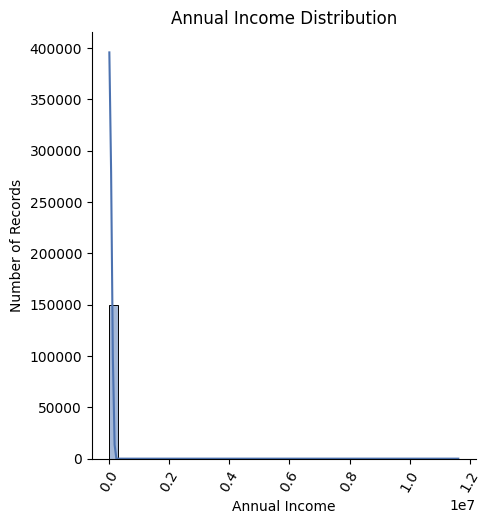

In [ ]:
column_name = 'Annual_Income'
group_by = 'Customer_ID'
user_friendly_name = 'Annual Income'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype='float')

# Plot Graph
plot_displot(df,column_name,user_friendly_name,bins=40, rotation = 60)

## Monthly Inhand

Details of Monthly_Inhand_Salary column

DataType:  float64

There are  22500  null values

Number of Unique Values:  13683

Distribution of column:

6082.187500     22
2295.058333     22
6358.956667     21
3080.555000     21
6639.560000     20
                ..
4305.385250      1
2028.727911      1
3065.776667      1
2486.532500      1
10699.849855     1
Name: Monthly_Inhand_Salary, Length: 13683, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min      303.645417
max    15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

After Cleaning Min, Max Values:
min      303.645417
max    15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

No. of Unique values after Cleaning: 13099

No. of Null values after Cleaning: 0

-----------------------------------------------------

Monthly Inhand Salary Distribution


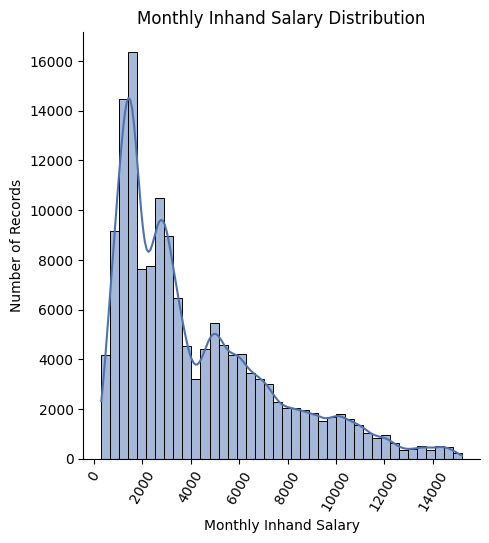

In [ ]:
column_name = 'Monthly_Inhand_Salary'
group_by = 'Customer_ID'
user_friendly_name = 'Monthly Inhand Salary'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

# Plot Graph
plot_displot(df,column_name,user_friendly_name,bins=40, rotation = 60)

### **Summary**

There are 22500 null values present.
No outliers were present for Monthly Income Salary.
Most customers have a low monthly income. Distribution is right skewed.

## New bank accounts

Details of Num_Bank_Accounts column

DataType:  int64

There are no null values

Number of Unique Values:  1183

Distribution of column:

6       19505
7       19231
8       19152
4       18286
5       18186
        ...  
1731        1
84          1
1458        1
1448        1
278         1
Name: Num_Bank_Accounts, Length: 1183, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min      -1
max    1798
Name: Num_Bank_Accounts, dtype: int64

After Cleaning Min, Max Values:
min      -1.0
max    1077.0
Name: Num_Bank_Accounts, dtype: float64

No. of Unique values after Cleaning: 99

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Bank Accounts Distribution


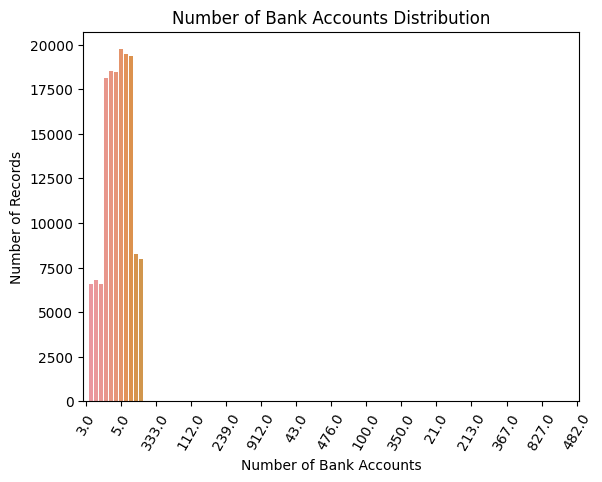

In [ ]:
column_name = 'Num_Bank_Accounts'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Bank Accounts'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

# Plot Graph
plot_countplot(df,column_name,user_friendly_name,max_xticks=13, rotation = 60)

### **Summary**

There are some outliers,negative values in Num Bank Accounts.

After cleaning, there are 11 possible value of this field: Num Bank Accounts ranging from 0 to 10.

Majority of customers has no. of bank accounts between 3 to 8.

## Num credit cards

Details of Num_Credit_Card column

DataType:  int64

There are no null values

Number of Unique Values:  1344

Distribution of column:

5       27669
7       24886
6       24802
4       21102
3       19816
        ...  
960         1
1331        1
1224        1
850         1
1209        1
Name: Num_Credit_Card, Length: 1344, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       0
max    1499
Name: Num_Credit_Card, dtype: int64

After Cleaning Min, Max Values:
min      0.0
max    914.0
Name: Num_Credit_Card, dtype: float64

No. of Unique values after Cleaning: 232

No. of Null values after Cleaning: 0

-----------------------------------------------------

Number of Credit Card Distribution


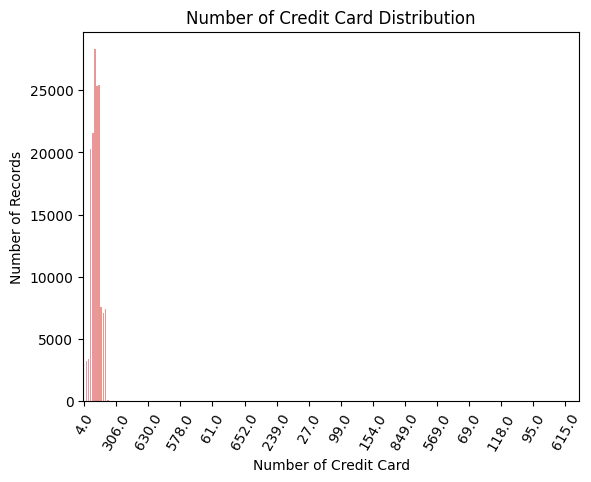

In [ ]:
column_name = 'Num_Credit_Card'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Credit Card'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

# Plot Graph
plt.xlim(0, 11)
plot_countplot(df,column_name,user_friendly_name,max_xticks=15, rotation = 60)


## Summary

There are outliers present in the field as there are 24 unique values of number of credit card.

After removing outliers, number of credit cards range from 0 to 11 with most of the customers having credit cards in the range of 3 to 7 with peak at 5.

## Intrest rate

Details of Interest_Rate column

DataType:  int64

There are no null values

Number of Unique Values:  2394

Distribution of column:

8       7515
5       7479
6       7089
12      6828
10      6799
        ... 
4985       1
2781       1
608        1
4817       1
4252       1
Name: Interest_Rate, Length: 2394, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       1
max    5799
Name: Interest_Rate, dtype: int64

After Cleaning Min, Max Values:
min       1.0
max    3213.0
Name: Interest_Rate, dtype: float64

No. of Unique values after Cleaning: 229

No. of Null values after Cleaning: 0

-----------------------------------------------------

Interest Rate Distribution


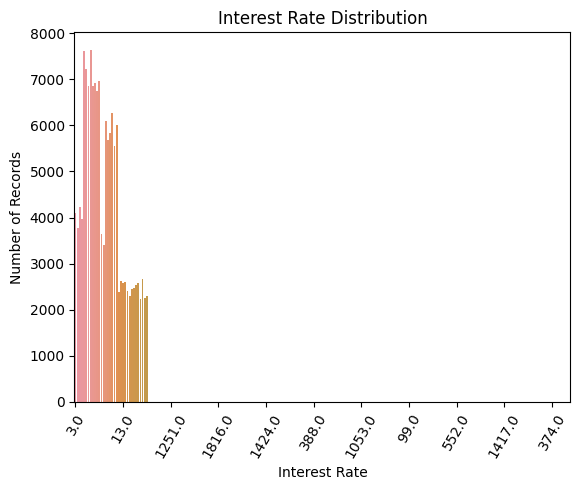

In [ ]:
column_name = 'Interest_Rate'
group_by = 'Customer_ID'
user_friendly_name = 'Interest Rate'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

# Plot Graph
plot_countplot(df,column_name,user_friendly_name,rotation=60,max_xticks=10)

### **Interest Rate Summary**

There were outliers present, after cleaning them up, interest rate ranges from 1% to 34%

## Delay from due date

Details of Delay_from_due_date column

DataType:  int64

There are no null values

Number of Unique Values:  73

Distribution of column:

 15    5355
 13    5185
 8     5004
 14    4949
 10    4926
       ... 
 63      90
 65      86
-5       51
 66      44
 67      29
Name: Delay_from_due_date, Length: 73, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min    -5
max    67
Name: Delay_from_due_date, dtype: int64

After Cleaning Min, Max Values:
min    -5.0
max    67.0
Name: Delay_from_due_date, dtype: float64

No. of Unique values after Cleaning: 73

No. of Null values after Cleaning: 0

-----------------------------------------------------

Delay from Due Date Distribution


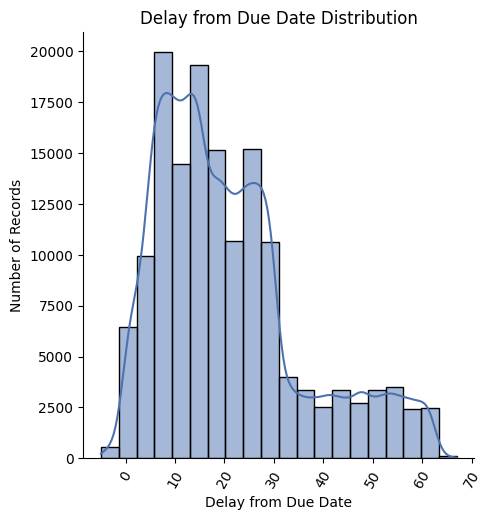

In [ ]:
column_name = 'Delay_from_due_date'
group_by = 'Customer_ID'
user_friendly_name = 'Delay from Due Date'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

# Plot Graph
plot_displot(df,column_name,user_friendly_name,rotation=60)

### **Summary**
Delay from due date is concentrated between 0 to 30 days.

## Number of delayed payment

In [ ]:
column_name = 'Num_of_Delayed_Payment'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Delayed Payment'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype='float')


Details of Num_of_Delayed_Payment column

DataType:  object

There are  10500  null values

Number of Unique Values:  1058

Distribution of column:

19      7949
17      7806
16      7721
15      7671
10      7670
        ... 
2728       1
1952       1
3580       1
4251       1
2034       1
Name: Num_of_Delayed_Payment, Length: 1058, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Num_of_Delayed_Payment is changed to float

Existing Min, Max Values:
min      -3.0
max    4399.0
Name: Num_of_Delayed_Payment, dtype: float64

After Cleaning Min, Max Values:
min      -3.0
max    2523.0
Name: Num_of_Delayed_Payment, dtype: float64

No. of Unique values after Cleaning: 63

No. of Null values after Cleaning: 0


## Changed credit limit

In [ ]:
column_name = 'Changed_Credit_Limit'
group_by = 'Customer_ID'
user_friendly_name = 'Changed Credit Limit'

#Get Details
get_column_details(df,column_name)

#Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype='float',replace_value='_')


Details of Changed_Credit_Limit column

DataType:  object

There are no null values

Number of Unique Values:  4605

Distribution of column:

_        3150
11.5      197
11.32     189
8.22      189
7.35      181
         ... 
34.57       1
31.94       1
34.46       1
23.32       1
29.17       1
Name: Changed_Credit_Limit, Length: 4605, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value _ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Changed_Credit_Limit is changed to float

Existing Min, Max Values:
min    -6.49
max    36.97
Name: Changed_Credit_Limit, dtype: float64

After Cleaning Min, Max Values:
min    -6.49
max    34.57
Name: Changed_Credit_Limit, dtype: float64

No. of Unique values after Cleaning: 4359

No. of Null values after Cleaning: 0


## Number of credit enquiries

In [ ]:
column_name = 'Num_Credit_Inquiries'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Credit Inquiries'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)

Details of Num_Credit_Inquiries column

DataType:  float64

There are  3000  null values

Number of Unique Values:  1607

Distribution of column:

4.0       15673
6.0       12486
3.0       12356
7.0       12353
8.0       11788
          ...  
1243.0        1
540.0         1
2150.0        1
1324.0        1
352.0         1
Name: Num_Credit_Inquiries, Length: 1607, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min       0.0
max    2597.0
Name: Num_Credit_Inquiries, dtype: float64

After Cleaning Min, Max Values:
min       0.0
max    1604.0
Name: Num_Credit_Inquiries, dtype: float64

No. of Unique values after Cleaning: 134

No. of Null values after Cleaning: 0


## Outstanding Debt

Details of Outstanding_Debt column

DataType:  object

There are no null values

Number of Unique Values:  13622

Distribution of column:

1360.45     36
1151.7      35
460.46      35
1109.03     35
3628.5      24
            ..
1639.82_     1
1340.52_     1
647.15_      1
1959.49_     1
732.11_      1
Name: Outstanding_Debt, Length: 13622, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Outstanding_Debt is changed to <class 'float'>

Existing Min, Max Values:
min       0.23
max    4998.07
Name: Outstanding_Debt, dtype: float64

After Cleaning Min, Max Values:
min       0.23
max    4998.07
Name: Outstanding_Debt, dtype: float64

No. of Unique values after Cleaning: 12203

No. of Null values after Cleaning: 0

-----------------------------------------------------

Outstanding Debt Distribution


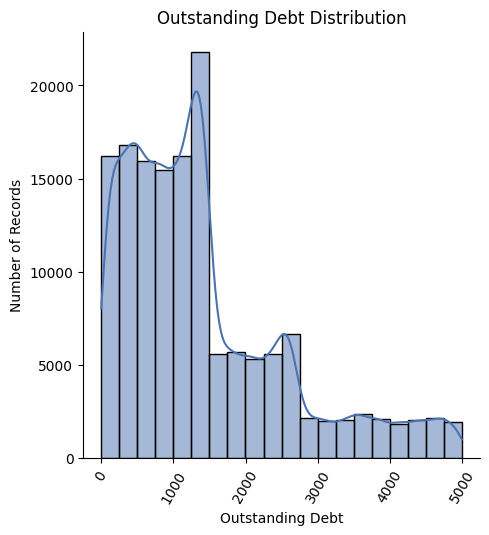

In [ ]:
column_name = 'Outstanding_Debt'
group_by = 'Customer_ID'
user_friendly_name = 'Outstanding Debt'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype=float)

# Plot Graph
plot_displot(df,column_name,user_friendly_name,rotation=60)

## Credit Utilization Ratio

In [ ]:
column_name = 'Credit_Utilization_Ratio'
group_by = 'Customer_ID'
user_friendly_name = 'Credit Utilization Ratio'

# Get Details
get_column_details(df,column_name)

Details of Credit_Utilization_Ratio column

DataType:  float64

There are no null values

Number of Unique Values:  150000

Distribution of column:

26.822620    1
39.377219    1
40.565631    1
41.255522    1
33.638208    1
            ..
26.650258    1
23.864244    1
29.638130    1
31.875399    1
34.108530    1
Name: Credit_Utilization_Ratio, Length: 150000, dtype: int64


## Credit history age

In [ ]:
df['Credit_History_Age'].value_counts()

def Month_Converter(val):
    if pd.notnull(val) and isinstance(val, str):
        years = int(val.split(' ')[0])
        month = int(val.split(' ')[3])
        return (years * 12) + month
    return val

df['Credit_History_Age'] = df['Credit_History_Age'].apply(lambda x: Month_Converter(x)).astype(float)

column_name = 'Credit_History_Age'
group_by = 'Customer_ID'
user_friendly_name = 'Credit History Age'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,datatype=float)

Details of Credit_History_Age column

DataType:  float64

There are  13500  null values

Number of Unique Values:  408

Distribution of column:

215.0    628
220.0    621
219.0    617
237.0    615
218.0    615
        ... 
3.0       20
2.0       15
407.0     15
408.0     14
1.0        2
Name: Credit_History_Age, Length: 408, dtype: int64

-----------------------------------------------------

Cleaning steps 

Datatype of Credit_History_Age is changed to <class 'float'>

Existing Min, Max Values:
min      1.0
max    408.0
Name: Credit_History_Age, dtype: float64

After Cleaning Min, Max Values:
min      1.0
max    404.0
Name: Credit_History_Age, dtype: float64

No. of Unique values after Cleaning: 404

No. of Null values after Cleaning: 0


## Total EMI Per month

In [ ]:
column_name = 'Total_EMI_per_month'
group_by = 'Customer_ID'
user_friendly_name = 'Total EMI per month'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name)


Details of Total_EMI_per_month column

DataType:  float64

There are no null values

Number of Unique Values:  16960

Distribution of column:

0.000000        15615
49.574949          12
16.528703          12
64.443403          12
331.719510         12
                ...  
10404.000000        1
15457.000000        1
59578.000000        1
43183.000000        1
33013.000000        1
Name: Total_EMI_per_month, Length: 16960, dtype: int64

-----------------------------------------------------

Cleaning steps 

Existing Min, Max Values:
min        0.0
max    82398.0
Name: Total_EMI_per_month, dtype: float64

After Cleaning Min, Max Values:
min        0.0
max    59898.0
Name: Total_EMI_per_month, dtype: float64

No. of Unique values after Cleaning: 12394

No. of Null values after Cleaning: 0


## Amount invested monthly


In [ ]:
column_name = 'Amount_invested_monthly'
group_by = 'Customer_ID'
user_friendly_name = 'Amount invested monthly'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,datatype=float,strip='_')

Details of Amount_invested_monthly column

DataType:  object

There are  6750  null values

Number of Unique Values:  136497

Distribution of column:

__10000__             6480
0.0                    275
463.83425645911626       1
16.53218878920387        1
205.21728040016708       1
                      ... 
209.17274569312266       1
333.0148085469461        1
274.68712877851107       1
220.58121173366908       1
220.45787812168732       1
Name: Amount_invested_monthly, Length: 136497, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Amount_invested_monthly is changed to <class 'float'>

Existing Min, Max Values:
min        0.0
max    10000.0
Name: Amount_invested_monthly, dtype: float64

After Cleaning Min, Max Values:
min        0.0
max    10000.0
Name: Amount_invested_monthly, dtype: float64

No. of Unique values after Cleaning: 113695

No. of Null values after Cleaning: 0


## Monthly balance

In [ ]:
column_name = 'Monthly_Balance'
group_by = 'Customer_ID'
user_friendly_name = 'Monthly Balance'

# Get Details
get_column_details(df,column_name)

# Cleaning
df[column_name].replace('',np.nan)
clean_numerical_field2(df,group_by,column_name,strip='_',datatype=float,replace_value='__-333333333333333333333333333__')


Details of Monthly_Balance column

DataType:  object

There are  1762  null values

Number of Unique Values:  148224

Distribution of column:

__-333333333333333333333333333__    15
312.49408867943663                   1
710.7857402489867                    1
698.6261872759807                    1
733.1224369379486                    1
                                    ..
279.9825060023594                    1
260.67157274114965                   1
250.4915113003876                    1
243.8753153006728                    1
360.37968260123847                   1
Name: Monthly_Balance, Length: 148224, dtype: int64

-----------------------------------------------------

Cleaning steps 

Garbage value __-333333333333333333333333333__ is replaced with np.nan

Trailing & leading _ are removed

Datatype of Monthly_Balance is changed to <class 'float'>

Existing Min, Max Values:
min       0.007760
max    1606.518192
Name: Monthly_Balance, dtype: float64

After Cleaning Min, Max Values:
min

## Number of loans

In [ ]:
column_name = 'Num_of_Loan'
group_by = 'Customer_ID'
user_friendly_name = 'Number of Loan'

# Get Details
get_column_details(df,column_name)

# Cleaning
clean_numerical_field2(df,group_by,column_name,strip='_',datatype=float)

Details of Num_of_Loan column

DataType:  object

There are no null values

Number of Unique Values:  623

Distribution of column:

3        21500
2        21423
4        20998
0        15543
1        15112
         ...  
291          1
365          1
1014         1
1129_        1
1296_        1
Name: Num_of_Loan, Length: 623, dtype: int64

-----------------------------------------------------

Cleaning steps 

Trailing & leading _ are removed

Datatype of Num_of_Loan is changed to <class 'float'>

Existing Min, Max Values:
min    -100.0
max    1496.0
Name: Num_of_Loan, dtype: float64

After Cleaning Min, Max Values:
min   -100.0
max    831.0
Name: Num_of_Loan, dtype: float64

No. of Unique values after Cleaning: 34

No. of Null values after Cleaning: 0


In [ ]:
#Check if null values are present
df.isna().sum()

ID                              0
Customer_ID                     0
Month                           0
Name                            0
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                    0
Delay_from_due_date             0
Num_of_Delayed_Payment          0
Changed_Credit_Limit            0
Num_Credit_Inquiries            0
Credit_Mix                      0
Outstanding_Debt                0
Credit_Utilization_Ratio        0
Credit_History_Age              0
Payment_of_Min_Amount           0
Total_EMI_per_month             0
Amount_invested_monthly         0
Payment_Behaviour               0
Monthly_Balance                 0
Credit_Score                50000
dtype: int64

# **Modeling**

## Exploring Correlation Using Correlogram

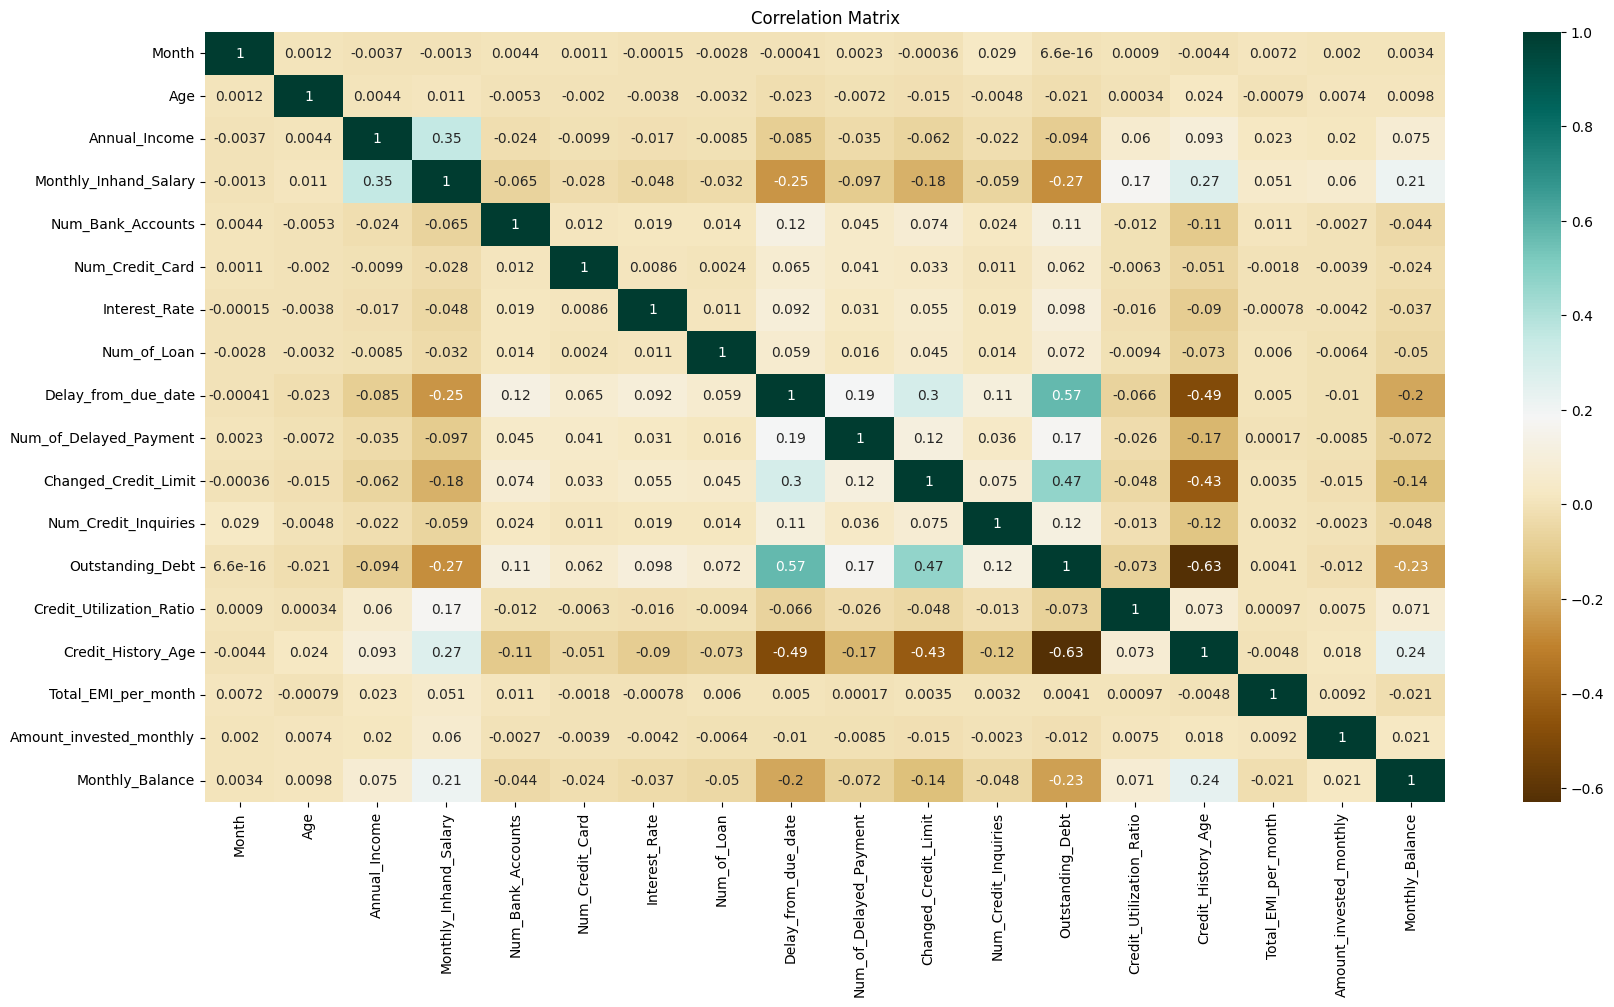

In [ ]:
cor_matrix = df.corr(numeric_only = True)

plt.figure(figsize=(20,10))
sns.heatmap(cor_matrix, annot = True, cmap = 'BrBG')
plt.title('Correlation Matrix')
plt.show()

## Variable Transformation and Dummy Variables

## Creating a new dataset to avoid altering the original one in case it is needed

In [ ]:
normalized_df = df.copy()

## Creating Dummy Variables for Occupation

In [ ]:
normalized_df = pd.get_dummies(normalized_df, prefix='Occupation', columns=['Occupation'], drop_first=False)
normalized_df.head(20)

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
8,0x160e,CUS_0x21b1,1,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
9,0x160f,CUS_0x21b1,2,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
# Replace True with 1 and False with 0 for the specified columns

# List of columns to convert
columns_to_convert = [
    'Occupation_Accountant', 'Occupation_Architect', 'Occupation_Developer',
    'Occupation_Doctor', 'Occupation_Engineer', 'Occupation_Entrepreneur',
    'Occupation_Journalist', 'Occupation_Lawyer', 'Occupation_Manager',
    'Occupation_Mechanic', 'Occupation_Media_Manager', 'Occupation_Musician',
    'Occupation_Scientist', 'Occupation_Teacher', 'Occupation_Writer'
]

# Convert boolean columns to numeric (0 and 1)
for column_name in columns_to_convert:
    normalized_df[column_name] = normalized_df[column_name].astype(int)

normalized_df.head(20)

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
8,0x160e,CUS_0x21b1,1,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
9,0x160f,CUS_0x21b1,2,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
normalized_df[columns_to_convert].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 15 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   Occupation_Accountant     150000 non-null  int64
 1   Occupation_Architect      150000 non-null  int64
 2   Occupation_Developer      150000 non-null  int64
 3   Occupation_Doctor         150000 non-null  int64
 4   Occupation_Engineer       150000 non-null  int64
 5   Occupation_Entrepreneur   150000 non-null  int64
 6   Occupation_Journalist     150000 non-null  int64
 7   Occupation_Lawyer         150000 non-null  int64
 8   Occupation_Manager        150000 non-null  int64
 9   Occupation_Mechanic       150000 non-null  int64
 10  Occupation_Media_Manager  150000 non-null  int64
 11  Occupation_Musician       150000 non-null  int64
 12  Occupation_Scientist      150000 non-null  int64
 13  Occupation_Teacher        150000 non-null  int64
 14  Occupation_Writer   

## Transforming and Changing Column Values to Numerical

In [ ]:
#Transform the information to the value as level

normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('Low_spent_Small_value_payments','1')
normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('Low_spent_Medium_value_payments','2')
normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('Low_spent_Large_value_payments','3')
normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('High_spent_Small_value_payments','4')
normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('High_spent_Medium_value_payments','5')
normalized_df['Payment_Behaviour'] = normalized_df['Payment_Behaviour'].astype(str).str.replace('High_spent_Large_value_payments','6')
normalized_df.head(20)

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
8,0x160e,CUS_0x21b1,1,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
9,0x160f,CUS_0x21b1,2,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
normalized_df['Payment_Behaviour'].value_counts()

1    42046
5    29292
6    22952
2    21676
4    17764
3    16270
Name: Payment_Behaviour, dtype: int64

In [ ]:
# Transform the target data to numerical
normalized_df['Credit_Score'] = normalized_df['Credit_Score'].str.replace('Good', '3', n=-1)
normalized_df['Credit_Score'] = normalized_df['Credit_Score'].str.replace('Standard', '2', n=-1)
normalized_df['Credit_Score'] = normalized_df['Credit_Score'].str.replace('Poor', '1', n=-1)
normalized_df['Credit_Score'] = normalized_df[['Credit_Score']].apply(pd.to_numeric)

normalized_df['Payment_of_Min_Amount'] = normalized_df['Payment_of_Min_Amount'].str.replace('NM', '0')
normalized_df['Payment_of_Min_Amount'] = normalized_df['Payment_of_Min_Amount'].str.replace('Yes', '1')
normalized_df['Payment_of_Min_Amount'] = normalized_df['Payment_of_Min_Amount'].str.replace('No', '2')
normalized_df['Payment_of_Min_Amount'] = normalized_df[['Payment_of_Min_Amount']].apply(pd.to_numeric)
normalized_df.head(20)

,ID,Customer_ID,Month,Name,Age,SSN,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,...,Occupation_Entrepreneur,Occupation_Journalist,Occupation_Lawyer,Occupation_Manager,Occupation_Mechanic,Occupation_Media_Manager,Occupation_Musician,Occupation_Scientist,Occupation_Teacher,Occupation_Writer
0,0x1602,CUS_0xd40,1,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
1,0x1603,CUS_0xd40,2,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
2,0x1604,CUS_0xd40,3,Aaron Maashoh,-500.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
3,0x1605,CUS_0xd40,4,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
4,0x1606,CUS_0xd40,5,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
5,0x1607,CUS_0xd40,6,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
6,0x1608,CUS_0xd40,7,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
7,0x1609,CUS_0xd40,8,Aaron Maashoh,23.0,821-00-0265,19114.12,1824.843333,3.0,4.0,...,0,0,0,0,0,0,0,1,0,0
8,0x160e,CUS_0x21b1,1,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0
9,0x160f,CUS_0x21b1,2,Rick Rothackerj,28.0,004-07-5839,34847.84,3037.986667,2.0,4.0,...,0,0,0,0,0,0,0,0,1,0


In [ ]:
normalized_df['Payment_of_Min_Amount'].value_counts()

1    78484
2    53516
0    18000
Name: Payment_of_Min_Amount, dtype: int64

In [ ]:
normalized_df.info()
normalized_df.describe()
normalized_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 42 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        150000 non-null  object 
 1   Customer_ID               150000 non-null  object 
 2   Month                     150000 non-null  int64  
 3   Name                      150000 non-null  object 
 4   Age                       150000 non-null  float64
 5   SSN                       150000 non-null  object 
 6   Annual_Income             150000 non-null  float64
 7   Monthly_Inhand_Salary     150000 non-null  float64
 8   Num_Bank_Accounts         150000 non-null  float64
 9   Num_Credit_Card           150000 non-null  float64
 10  Interest_Rate             150000 non-null  float64
 11  Num_of_Loan               150000 non-null  float64
 12  Type_of_Loan              150000 non-null  object 
 13  Delay_from_due_date       150000 non-null  f

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'Occupation_Accountant', 'Occupation_Architect',
       'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
       'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
       'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer'],
      dtype='object')

## Exploring Correlation Using Correlogram - After Dataset Alterations

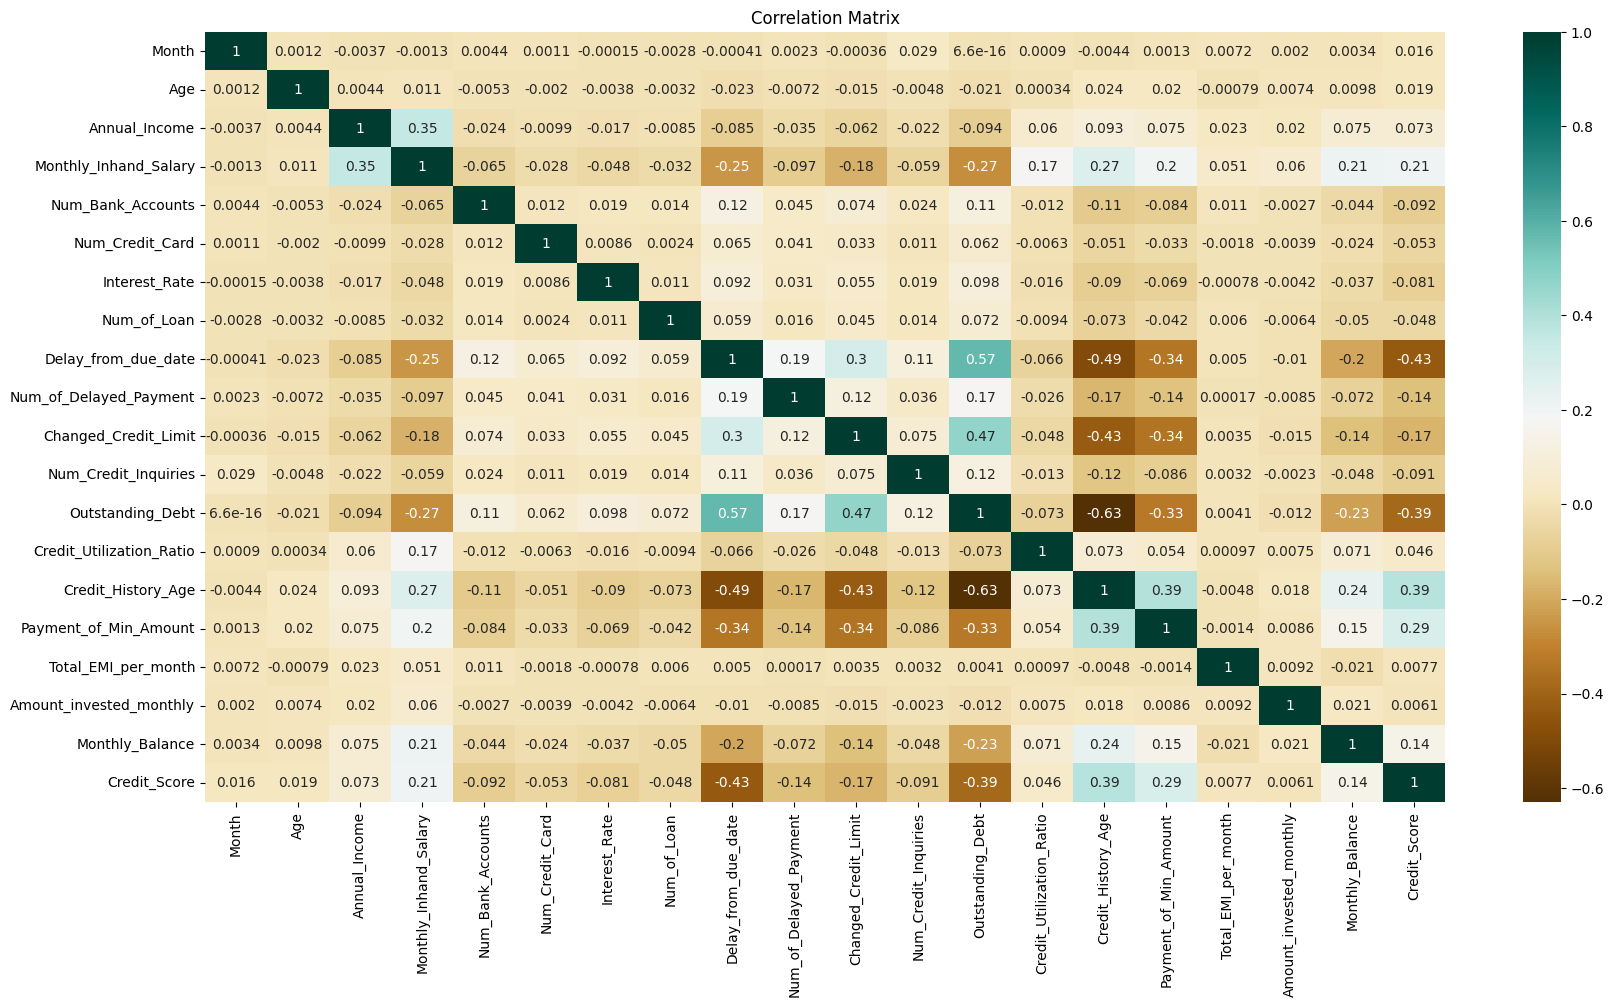

In [ ]:
cor_matrix_normalized = normalized_df.drop(['Occupation_Accountant', 'Occupation_Architect',
       'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
       'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
       'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager',
       'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
       'Occupation_Writer'], axis=1).corr(numeric_only= True)

plt.figure(figsize=(20, 10))
sns.heatmap(cor_matrix_normalized, annot=True, cmap='BrBG')
plt.title('Correlation Matrix')
plt.show()

## Selecting Features

In [ ]:
features = ['Age', 'Annual_Income', 'Num_of_Delayed_Payment',
            'Credit_History_Age', 'Payment_of_Min_Amount', 'Delay_from_due_date',
            'Payment_Behaviour', 'Monthly_Balance',
            'Occupation_Accountant', 'Occupation_Architect',
            'Occupation_Developer', 'Occupation_Doctor', 'Occupation_Engineer',
            'Occupation_Entrepreneur', 'Occupation_Journalist', 'Occupation_Lawyer',
            'Occupation_Manager', 'Occupation_Mechanic', 'Occupation_Media_Manager',
            'Occupation_Musician', 'Occupation_Scientist', 'Occupation_Teacher',
            'Occupation_Writer']

df_train_x = normalized_df[features]
df_train_y = normalized_df['Credit_Score']

In [ ]:
normalized_df[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Age                       150000 non-null  float64
 1   Annual_Income             150000 non-null  float64
 2   Num_of_Delayed_Payment    150000 non-null  float64
 3   Credit_History_Age        150000 non-null  float64
 4   Payment_of_Min_Amount     150000 non-null  int64  
 5   Delay_from_due_date       150000 non-null  float64
 6   Payment_Behaviour         150000 non-null  object 
 7   Monthly_Balance           150000 non-null  float64
 8   Occupation_Accountant     150000 non-null  int64  
 9   Occupation_Architect      150000 non-null  int64  
 10  Occupation_Developer      150000 non-null  int64  
 11  Occupation_Doctor         150000 non-null  int64  
 12  Occupation_Engineer       150000 non-null  int64  
 13  Occupation_Entrepreneur   150000 non-null  i

## K-Means Clustering

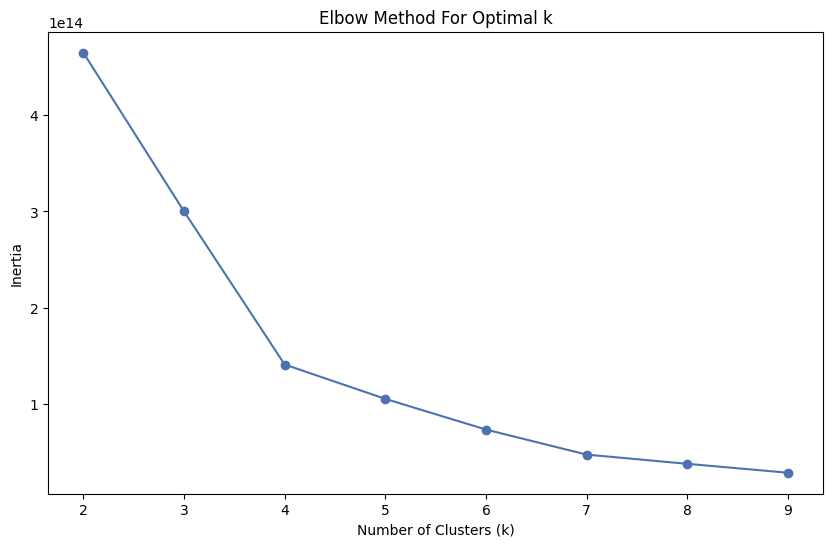

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming normalized_df and features are defined
df_features = normalized_df[features]

# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
df_features_imputed = imputer.fit_transform(df_features)

# Create a range of possible cluster numbers
possible_k_values = range(2, 10)

# Store inertias for each k
inertias = []

for k in possible_k_values:
    # Initialize the KMeans model for the current k
    kmeans = KMeans(n_clusters=k, random_state=42)

    # Fit the model to your data
    kmeans.fit(df_features_imputed)

    # Get the inertia (sum of squared distances to the closest centroid)
    inertias.append(kmeans.inertia_)

# Plot the inertias against the number of clusters (k)
plt.figure(figsize=(10, 6))
plt.plot(possible_k_values, inertias, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()

## K-Means Plot

Optimal number of clusters (k): 3


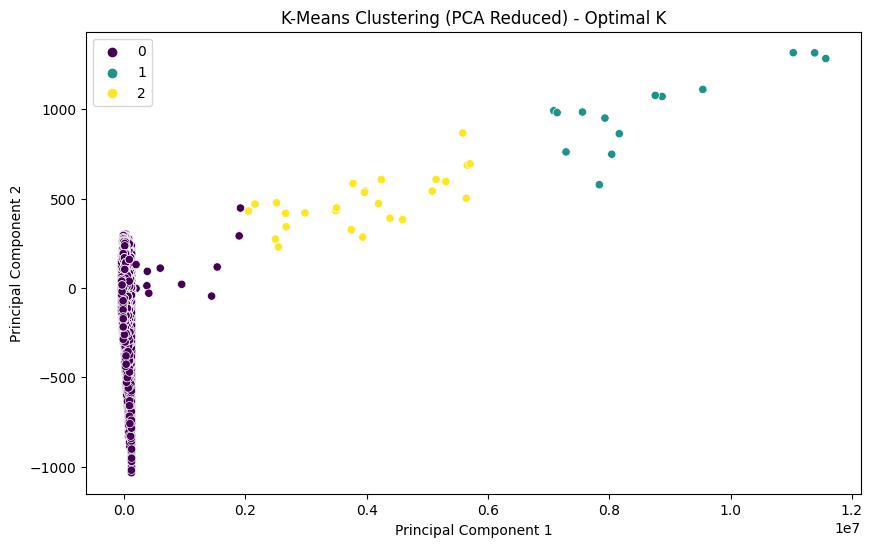

In [ ]:
# Find the optimal k based on the elbow in the plot
optimal_k = 3

# Print the optimal k
print(f"Optimal number of clusters (k): {optimal_k}")

# Re-run KMeans with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(df_features_imputed)

# Apply PCA to reduce the dimensionality
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(df_features_imputed)

# Add a new column to your dataframe with the cluster assignments
normalized_df['Cluster'] = kmeans.labels_

# Visualize the clusters in the reduced space
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=kmeans.labels_, palette='viridis')
plt.title('K-Means Clustering (PCA Reduced) - Optimal K')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

## KNN

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

df_features = normalized_df[features]
df_target = normalized_df['Credit_Score']

# Handle NaN values in features using SimpleImputer
imputer = SimpleImputer(strategy='mean')  # You can choose other strategies like 'median' or 'most_frequent'
df_features_imputed = imputer.fit_transform(df_features)

# Handle NaN values in the target variable by removing those rows
df_target_cleaned = df_target.dropna()

# Align the features with the cleaned target variable
df_features_cleaned = df_features_imputed[:len(df_target_cleaned)]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(df_features_cleaned, df_target_cleaned, test_size=0.30, random_state=42)

# Initialize a KNeighborsRegressor model
knn_model = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors

# Train the model
knn_model.fit(x_train, y_train)

# Make predictions on the test set
y_pred = knn_model.predict(x_test)

# Evaluate the model using Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.23576533333333335



## First Decision Tree Model

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# Assuming df_features_cleaned and df_target_cleaned are your feature and target DataFrames
x_train, x_test, y_train, y_test = train_test_split(df_features_cleaned, df_target_cleaned, test_size=0.30, random_state=42)

# Creating and training the Decision Tree model
dtree = DecisionTreeClassifier(random_state=1)
dtree = dtree.fit(x_train, y_train)

# Making predictions on the test set
y_pred = dtree.predict(x_test)

# Calculating various metrics
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
classification_rep = classification_report(y_test, y_pred)

# Printing the results
print("Confusion Matrix:")
print(cm)
print("\nAccuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[ 6003  2568   234]
 [ 2547 11537  1789]
 [  241  1809  3272]]

Accuracy: 0.6937333333333333
Precision: 0.6936173699479893
Recall: 0.6937333333333333
F1 Score: 0.6936738787326946

Classification Report:
              precision    recall  f1-score   support

         1.0       0.68      0.68      0.68      8805
         2.0       0.72      0.73      0.73     15873
         3.0       0.62      0.61      0.62      5322

    accuracy                           0.69     30000
   macro avg       0.68      0.67      0.67     30000
weighted avg       0.69      0.69      0.69     30000



## Correlogram

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Credit_Score1'] = le.fit_transform(df['Credit_Score'])
test_df = df[df['Credit_Score'].isna()]
train_df = df[df['Credit_Score'].notna()]

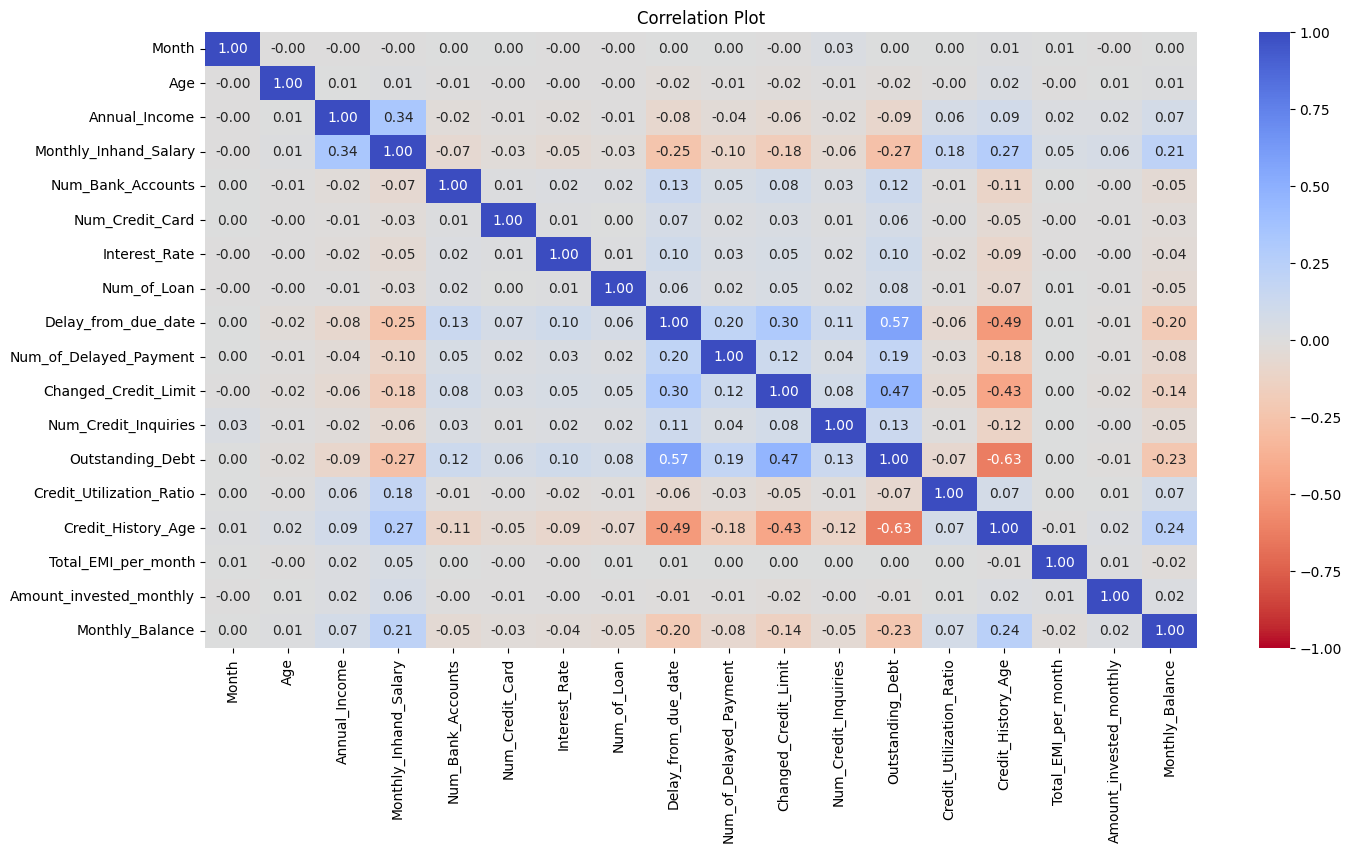

In [ ]:
selected_cols = [n for n in df.columns if df[n].dtypes not in ['O'] and n != 'Credit_Score1' and n!='Credit_Score']
correlation_matrix = train_df[selected_cols].corr()

# Create a heatmap using seaborn
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm_r', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Plot')
plt.show()

## Normalization

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(train_df[selected_cols])
scaled_train_df = scaler.transform(train_df[selected_cols])

In [ ]:
sp_train_df = scaled_train_df[(train_df['Credit_Score1'] == 2) | (train_df['Credit_Score1'] == 1)]
sg_train_df = scaled_train_df[(train_df['Credit_Score1'] == 2) | (train_df['Credit_Score1'] == 0)]
pg_train_df = scaled_train_df[(train_df['Credit_Score1'] == 1) | (train_df['Credit_Score1'] == 0)]

## Second Decision Tree Model - Stratified K Fold

***With slightly different features than First Decision Tree Model***

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report

stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform stratified k-fold cross-validation with SVC
X = np.array(train_df[selected_cols])
y = np.array(train_df['Credit_Score1'])

best_accuracy = 0
for train_idx, val_idx in stratified_kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Initialize and fit SVC model
    tree_model = DecisionTreeClassifier(random_state=42)  # You can choose different kernels ('linear', 'rbf', etc.)
    tree_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = tree_model.predict(X_val)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred)

    print("Validation Accuracy:", accuracy)
    print("===")

    if accuracy > best_accuracy:
        best_model = tree_model
        best_accuracy = accuracy

    print(classification_report(y_val, y_pred))

y_test = tree_model.predict(test_df[selected_cols])
test_df.loc[:,'Credit_Score1'] = y_test

Validation Accuracy: 0.7177356452870942
===
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      5943
           1       0.71      0.70      0.70      9666
           2       0.75      0.75      0.75     17725

    accuracy                           0.72     33334
   macro avg       0.70      0.70      0.70     33334
weighted avg       0.72      0.72      0.72     33334

Validation Accuracy: 0.7303573035730357
===
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      5943
           1       0.73      0.71      0.72      9666
           2       0.76      0.77      0.76     17724

    accuracy                           0.73     33333
   macro avg       0.71      0.71      0.71     33333
weighted avg       0.73      0.73      0.73     33333

Validation Accuracy: 0.7275972759727597
===
              precision    recall  f1-score   support

           0       0.66      0.67      0.67      59

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
<ipython-input-147-c58727d9226a>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.loc[:,'Credit_Score1'] = y_test


In [ ]:
stratified_kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Perform stratified k-fold cross-validation with SVC
X = sp_train_df
y = np.array(train_df[(train_df['Credit_Score1'] == 2) | (train_df['Credit_Score1'] == 1)]['Credit_Score1'])

best_accuracy1 = 0
for train_idx, val_idx in stratified_kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Initialize and fit SVC model
    tree_model = DecisionTreeClassifier(random_state=42)  # You can choose different kernels ('linear', 'rbf', etc.)
    tree_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = tree_model.predict(X_val)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred)

    print("Validation Accuracy:", accuracy)
    print("===")

    if accuracy > best_accuracy:
        best_model1 = tree_model
        best_accuracy1 = accuracy

Validation Accuracy: 0.8029279690409259
===
Validation Accuracy: 0.8086597787594465
===
Validation Accuracy: 0.8085067542898868
===


In [ ]:
X = sg_train_df
y = np.array(train_df[(train_df['Credit_Score1'] == 2) | (train_df['Credit_Score1'] == 0)]['Credit_Score1'])

best_accuracy2 = 0
for train_idx, val_idx in stratified_kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Initialize and fit SVC model
    tree_model = DecisionTreeClassifier(random_state=42)  # You can choose different kernels ('linear', 'rbf', etc.)
    tree_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = tree_model.predict(X_val)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred)

    print("Validation Accuracy:", accuracy)
    print("===")

    if accuracy > best_accuracy:
        best_model2 = tree_model
        best_accuracy2 = accuracy

Validation Accuracy: 0.8301081629203988
===
Validation Accuracy: 0.8303122491232517
===
Validation Accuracy: 0.8332699539443107
===


In [ ]:
X = pg_train_df
y = np.array(train_df[(train_df['Credit_Score1'] == 1) | (train_df['Credit_Score1'] == 0)]['Credit_Score1'])

for train_idx, val_idx in stratified_kfold.split(X, y):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Initialize and fit SVC model
    tree_model = DecisionTreeClassifier(random_state=42)  # You can choose different kernels ('linear', 'rbf', etc.)
    tree_model.fit(X_train, y_train)

    # Predict on validation set
    y_pred = tree_model.predict(X_val)

    # Calculate accuracy for this fold
    accuracy = accuracy_score(y_val, y_pred)

    print("Validation Accuracy:", accuracy)
    print("===")

Validation Accuracy: 0.9357422000128132
===
Validation Accuracy: 0.9420846947274009
===
Validation Accuracy: 0.9460533059969246
===


## DBSCAN - PCA

Estimated number of clusters: 6
Estimated number of noise points: 409


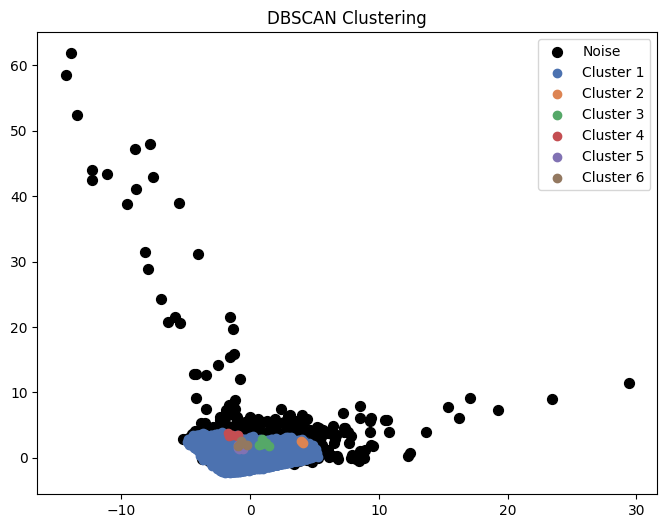

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(scaled_train_df)
X_pca = pca.transform(scaled_train_df)

from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples as needed

# Fit the DBSCAN model
dbscan.fit(X_pca)

labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise points
n_noise_ = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters_}')
print(f'Estimated number of noise points: {n_noise_}')

# Plotting the clusters and noise points
plt.figure(figsize=(8, 6))

# Plotting noise points (cluster label -1)
plt.scatter(X_pca[labels == -1][:, 0], X_pca[labels == -1][:, 1], c='black', marker='o', s=50, label='Noise')

# Plotting clusters
for i in range(n_clusters_):
    plt.scatter(X_pca[labels == i][:, 0], X_pca[labels == i][:, 1], label=f'Cluster {i + 1}')

plt.title('DBSCAN Clustering')
plt.legend()
plt.show()